# Pros of added details

author: laquitainesteeve@gmail.com

Execution time:

Tested on Ubuntu 24.04.1 LTS (32 cores, 188 GB RAM, Intel(R) Core(TM) i9-14900K ＠3.2 GHz/5.8 GHz) with RTX 5090 GPU with 40GB VRAM

prerequisites:
- 15 MB to store cell models
- sorted recordings with kilosort4  
    - Buccino [DONE]
    - Buccino clone [DONE]

Note:
- the original Buccino dataset has no metadata about the cells and we have no control on the parameters so we used MEAREC to re-simulate it, then we'll modify one parameter at a time.

## Setup 

Activate mearec virtual environment

In [ ]:
%%time
%load_ext autoreload
%autoreload 2

# import packages
import MEArec as mr
import os 
import numpy as np
import spikeinterface.extractors as se 
import spikeinterface.sorters as sorters 
import spikeinterface.comparison as sc  
from matplotlib import pyplot as plt;
import spikeinterface as si
from spikeinterface import extract_waveforms
import spikeinterface.qualitymetrics as sqm
import spikeinterface.core.template_tools as ttools
from numpy.linalg import norm as lalgnorm

# SET PROJECT PATH

PROJ_PATH = "/home/steeve/steeve/epfl/code/spikebias/"
os.chdir(PROJ_PATH)

# SET DATA PATHS

# original buccino simulation
RECORDING_BUCCINO_PATH = 'dataset/01_intermediate/preprocessing/recording_buccino/'
WAVEFORM_BUCCINO_PATH =  './temp/pros_of_details/waveformextractor_buccino/'

# clone of buccino simulation
tpl_prms = mr.get_default_templates_params()
tpl_prms['probe'] = 'Neuropixels-384'           # neuropixel probe
tpl_prms['n'] = 200                             # number of templates per cell model
tpl_prms['seed'] = 0                            # setup reproducibility
DATA_PATH = './temp/pros_of_details/'
CELLS_PATH = mr.get_default_cell_models_folder()
TEMPLATES_PATH = './temp/pros_of_details/templates.h5'
RECORDING_CLONE_H5_PATH = './temp/pros_of_details/recordings.h5'
RECORDING_CLONE_PATH = 'dataset/00_raw/recording_buccino_clone/'
SORTING_CLONE_PATH = 'dataset/00_raw/sorting_buccino_clone/'
WAVEFORM_CLONE_PATH =  './temp/pros_of_details/waveformextractor_buccino_clone/'
N_JOBS = 20
CHUNKS = 50000

# parallel processing parameters 
job_kwargs = dict(n_jobs=-1, chunk_duration="1s", progress_bar=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CPU times: user 3.15 ms, sys: 19 µs, total: 3.17 ms
Wall time: 3.01 ms


## Custom functions

In [381]:
# UTILS 

def _euclidean_distance(coord_1, coord_2):
    return np.sqrt(np.sum((coord_1 - coord_2) ** 2))


def mad(data):
    mean_data = np.mean(data)
    return np.mean(np.absolute(data - mean_data))


def get_mad_ratio(spike_amp, noise_amp):
    """calculate an sd_ratio robust to outliers

    Args:
        spike_amp (_type_): _description_
        noise_amp (_type_): _description_

    Returns:
        _type_: _description_
    """
    mad_unit = mad(spike_amp)  # twice smaller than std
    mad_noise = mad(noise_amp)
    return mad_unit / mad_noise


def get_best_site_mad_noise(we, max_chids, unit):

    # get waveforms
    wv, _ = we.get_waveforms(unit_id=unit, with_index=True)

    # get channel ids (sparse)
    c_ids = we.sparsity.unit_id_to_channel_ids[unit]

    # get nearest channel
    max_chid = max_chids[unit]
    max_chid_ix = np.where(c_ids == max_chid)[0][0]
    return wv[:, :, max_chid_ix].flatten()


def get_waveform_amplitudes_per_unit(We):
    return si.postprocessing.compute_spike_amplitudes(We, peak_sign="neg", outputs="by_unit")[0]


# QUALITY METRICS FOR A SINGLE UNIT

def get_spatial_spread(
    We, unit_id: int, max_chids: dict, channel_ids, channel_coord
):
    """measure unit's spatial spread

    Args:
        unit_id (int): _description_
        max_chids (dict): _description_
        Recording (_type_): _description_
        channel_ids (_type_): _description_
        channel_coord (_type_): _description_

    Returns:
        _type_: _description_
    """
    # get waveforms
    wv, _ = We.get_waveforms(unit_id=unit_id, with_index=True)    

    # get the site ids (sparse)
    c_ids = We.sparsity.unit_id_to_channel_ids[unit_id]

    # get the nearest site
    max_chid = max_chids[unit_id]
    max_chid_ix = np.where(c_ids == max_chid)[0][0]
    
    # get the average spike on each site
    mean_spikes = wv.mean(axis=0)
    max_spike = mean_spikes[:, max_chid_ix]
    
    # measure the average spike's similarity 
    # of each site to the average spike
    # of the nearest site to the unit
    # (ratio between 0 and 1)
    n_sites = mean_spikes.shape[1]
    cosim_weights = []
    for s_i in range(n_sites):
        cosim_weights.append(
            np.dot(max_spike, mean_spikes[:, s_i])
            / (lalgnorm(max_spike) * lalgnorm(mean_spikes[:, s_i]))
        )
    cosim_weights = np.array(cosim_weights)

    # threshold the similarity metric to be positive
    # we only look at similarity (not inverse similarity (<0))
    cosim_weights[cosim_weights < 0] = 0

    # measure the distance of the site to the nearest site
    # to the unit
    channel_coord = channel_coord[np.isin(channel_ids, c_ids), :]
    try:
        max_chids_coord = channel_coord[max_chid_ix, :]
    except:
        from ipdb import set_trace; set_trace()
        
    dist = []
    for ix, _ in enumerate(c_ids):
        dist.append(_euclidean_distance(max_chids_coord, channel_coord[ix]))
    dist = np.array(dist)

    # return spatial spread
    return {
        "spatial_spread": np.dot(cosim_weights, dist),
        "channel_distance": dist,
        "weights": cosim_weights,
    }


# QUALITY METRICS / SPIKE FEATURES FOR ALL UNITS

def get_firing_rates(sorting, duration_s):
    """
    Plots the firing rate distribution of units in a sorting extractor.

    Parameters:
    - sorting: spikeinterface SortingExtractor
        The sorting extractor containing spike trains.
    - duration_s: the total duration
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    unit_ids = sorting.get_unit_ids()
    firing_rates = [
        len(sorting.get_unit_spike_train(unit_id)) / duration_s
        for unit_id in unit_ids
    ]
    return firing_rates


def get_firing_ranges(waveform_extractor):

    firing_range = sqm.compute_firing_ranges(waveform_extractor=waveform_extractor)
    return np.array(list(firing_range.values()))


def get_waveform_amplitude_medians(waveform_extractor):

    amplitude_medians = sqm.compute_amplitude_medians(waveform_extractor=waveform_extractor)
    return np.array(list(amplitude_medians.values()))


def get_waveform_snr(waveform_extractor):

    amplitude_medians = sqm.compute_snrs(waveform_extractor=waveform_extractor)
    return np.array(list(amplitude_medians.values()))


def get_spatial_spread_all_units(
    recording_path: str, study_path: str, ms_before=3, ms_after=3, peak_sign="neg"
):
    """get all units' spatial extent metrics

    Args:
        recording_path (str): Path of the Recording Extractor
        study_path (str): _description_
        ms_before (float): _description_
        ms_after (float): _description_

    Returns:
        (dict): spatial spread of each unit
        - key: true unit id
        - value: spatial spread
    
    Prerequisites:
        - have extracted ground truth waveforms
    """
    # takes 1:30 min

    # get Waveform extractor
    Recording = si.load_extractor(recording_path)
    
    # WvfExtractor = waveform.load(
    #     Recording, study_path, ms_before=ms_before, ms_after=ms_after
    # )
    We = si.WaveformExtractor.load_from_folder(study_path)
    
    # get sites' distance to the max site
    # get 3D coordinates
    #Recording = si.load_extractor(recording_path)
    #channel_ids = Recording.get_channel_ids()
    Rec = si.load_extractor(recording_path)
    channel_coord = Rec.get_probe().contact_positions
    channel_ids = Rec.get_channel_ids()

    # get channels where spike amplitude is maximal
    max_chids = ttools.get_template_extremum_channel(
        We, peak_sign=peak_sign)

    # takes 1:30 min (1310 units)
    spatial_spread = dict()
    for _, unit in enumerate(We.unit_ids):
        spatial_spread[unit] = get_spatial_spread(
            We, unit, max_chids, channel_ids, channel_coord
        )["spatial_spread"]
    return np.array(list(spatial_spread.values()))


def get_mad_ratios(WeOriginal):
    """get mad ratio per unit

    Args:
        WeOriginal (WaveformExtractor): _description_

    Returns:
        np.array: mad ratio per unit
    """
    # pre-compute negative spike amplitudes
    amplitudes_by_unit = get_waveform_amplitudes_per_unit(WeOriginal)

    # get nearest channels
    max_chids = ttools.get_template_extremum_channel(WeOriginal, peak_sign="both")

    # compute mad ratio per unit
    mad_ratio = []
    for unit in WeOriginal.unit_ids:
        noise_amp = get_best_site_mad_noise(WeOriginal, max_chids, unit)
        mad_ratio.append(get_mad_ratio(amplitudes_by_unit[unit], noise_amp))
    return np.array(mad_ratio)

# PLOTS 

def plot_firing_rate_distribution(ax, firing_rates, bins=20, title:str='simulation_name'):
    """
    Plots the firing rate distribution of units in a sorting extractor.

    Parameters:
    - firing rates: firing rates
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(firing_rates, bins=bins, edgecolor='k')
    ax.set_xlabel("Firing rate (Hz)")
    ax.set_ylabel("Unit count")
    ax.set_title(title)


def plot_firing_ranges_distribution(ax, firing_ranges, bins=20, title:str='simulation_name', ylim=(0,50), xlim=(0,800)):
    """
    Parameters:
    - amplitudes: waveform amplitudes
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(firing_ranges, bins=bins, edgecolor='k')
    ax.set_xlabel("Firing range (Hz)")
    ax.set_ylabel("Unit count")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_title(title)


def plot_waveform_amplitude_median_distribution(ax, amplitudes, bins=20, title:str='simulation_name', ylim=(0,50), xlim=(0,800)):
    """
    Parameters:
    - amplitudes: waveform amplitudes
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(amplitudes, bins=bins, edgecolor='k')
    ax.set_xlabel("Amplitudes (uV)")
    ax.set_ylabel("Unit count")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_title(title)


def plot_waveform_snr_distribution(ax, snrs, bins=20, title:str='simulation_name', ylim=(0,50), xlim=(0,800)):
    """
    Parameters:
    - snrs: snrs
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(snrs, bins=bins, edgecolor='k')
    ax.set_xlabel("Signal-to-noise ratio (SNR)")
    ax.set_ylabel("Unit count")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_title(title)


def plot_spatial_spread_distribution(ax, mad_ratio, bins=20, title:str='simulation_name', ylim=(0,50), xlim=(0,800)):
    """
    Parameters:
    - mad_ratio: mad_ratio
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(mad_ratio, bins=bins, edgecolor='k')
    ax.set_xlabel("MAD ratio (a.u)")
    ax.set_ylabel("Unit count")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_title(title)


def plot_mad_ratio_distribution(ax, mad_ratios, bins=20, title:str='simulation_name', ylim=(0,50), xlim=(0,800)):
    """
    Parameters:
    - mad_ratios: waveform mean-absolute deviation ratio between spike amplitude and background noise
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(mad_ratios, bins=bins, edgecolor='k')
    ax.set_xlabel("MAD ratios (a.u)")
    ax.set_ylabel("Unit count")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_title(title)

In [ ]:
# Cells models take 15 MB
print("Dowloaded cells path:", CELLS_PATH)

# takes 10 min for 200 templates per cell model
# generate template
tpl_gen = mr.gen_templates(cell_models_folder=CELLS_PATH, params=tpl_prms)

# save templates
mr.save_template_generator(tpl_gen, TEMPLATES_PATH)

# setup recording parameters (takes 22 min)
rec_prms = mr.get_default_recordings_params()
rec_prms['spiketrains']['n_exc'] = 200
rec_prms['spiketrains']['n_inh'] = 50
rec_prms['spiketrains']['duration'] = 600
rec_prms['seeds']['spiketrains'] = 0
rec_prms['seeds']['templates'] = 1
rec_prms['seeds']['noise'] = 2
rec_prms['seeds']['convolution'] = 3

# generate and save recordings
rec_gen = mr.gen_recordings(params=rec_prms, templates=TEMPLATES_PATH)
mr.save_recording_generator(rec_gen, RECORDING_PATH)

# load H5 recording and ground-truth sorting
RecordingClone = se.MEArecRecordingExtractor(RECORDING_CLONE_H5_PATH) 
RecordingClone.set_property("layers", np.array(['L5']*384)) # add layer metadata
SortingClone = se.MEArecSortingExtractor(RECORDING_CLONE_H5_PATH)

# save as extractors
RecordingClone.save(folder=RECORDING_CLONE_PATH, n_jobs=N_JOBS, 
            verbose=True, progress_bar=True, overwrite=True, 
            dtype="float32", chunk_size=CHUNKS)
SortingClone.save(folder=SORTING_CLONE_PATH, overwrite=True)

Setting n_jobs to 32 CPUs
Running with 32 jobs


Starting 1


 /home/steeve/.config/mearec/1.8.0/cell_models/bbp/L5_BP_bAC217_1 1/13


Intracellular simulation: /home/steeve/.config/mearec/1.8.0/cell_models/bbp/L5_BP_bAC217_1



Cell has already be simulated. Using stored membrane currents



Extracellular simulation: /home/steeve/.config/mearec/1.8.0/cell_models/bbp/L5_BP_bAC217_1
Starting 9


 /home/steeve/.config/mearec/1.8.0/cell_models/bbp/L5_SBC_bNAC219_1 9/13


Starting 11


 /home/steeve/.config/mearec/1.8.0/cell_models/bbp/L5_TTPC1_cADpyr232_1 11/13


Starting 5


 /home/steeve/.config/mearec/1.8.0/cell_models/bbp/L5_LBC_bAC217_1 5/13


Starting 3


 /home/steeve/.config/mearec/1.8.0/cell_models/bbp/L5_ChC_cACint209_1 3/13


Starting 12


 /home/steeve/.config/mearec/1.8.0/cell_models/bbp/L5_TTPC2_cADpyr232_1 12/13


Starting 7


 /home/steeve/.config/mearec/1.8.0/cell_models/bbp/L5_NBC_bAC217_1 7/13


Starting 13


 /home/steeve/.config/mearec/1.8.0/cell_models/bbp/L5_UTPC_cADpyr232_1 13/13


Intracellular simulation: /home

--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


Intracellular simulation: /home/steeve/.config/mearec/1.8.0/cell_models/bbp/L5_NBC_bAC217_1



Cell has already be simulated. Using stored membrane currents



Extracellular simulation: /home/steeve/.config/mearec/1.8.0/cell_models/bbp/L5_NBC_bAC217_1
Starting 4


 /home/steeve/.config/mearec/1.8.0/cell_models/bbp/L5_DBC_bAC217_1 4/13


Intracellular simulation: /home/steeve/.config/mearec/1.8.0/cell_models/bbp/L5_UTPC_cADpyr232_1



Cell has already be simulated. Using stored membrane currents



Extracellular simulation: /home/steeve/.config/mearec/1.8.0/cell_models/bbp/L5_UTPC_cADpyr232_1
Starting 8


 /home/steeve/.config/mearec/1.8.0/cell_models/bbp/L5_NGC_bNAC219_1 8/13


Intracellular simulation: /home/steeve/.config/mearec/1.8.0/cell_models/bbp/L5_BTC_bAC217_1



Cell has already be simulated. Using stored membrane currents



Extracellular simulation: /home/steeve/.config/mearec/1.8.0/cell_models/bbp/L5_BTC_bAC217_1
Intracellular simulation: /home/steeve/.config/mearec/1.8.0/c

--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


Seed = 8
Seed = 4
Setting temperature to 34.000000 C
Setting simulation time step to 0.025000 ms
	1 
	1 
	1 
template bNAC219_L5_SBC_77ab259b7f exist already
Seed = 2
Setting temperature to 34.000000 C
Setting simulation time step to 0.025000 ms
	1 
	1 
	1 
template bAC217_L5_LBC_c2cff91741 exist already
Setting temperature to 34.000000 C
Setting simulation time step to 0.025000 ms
	1 
	1 
	1 
Seed = 6
template cACint209_L5_ChC_e98f63217d exist already
Seed = 12
Seed = 1
Setting temperature to 34.000000 C
Setting simulation time step to 0.025000 ms
	1 
	1 
	1 
template cADpyr232_L5_UTPC_5e3840b51e exist already
Setting temperature to 34.000000 C
Setting simulation time step to 0.025000 ms
	1 
	1 
	1 
template bAC217_L5_NBC_2db880c523 exist already
Seed = 10
Setting temperature to 34.000000 C
Setting simulation time step to 0.025000 ms
	1 
	1 
	1 
template bAC217_L5_BTC_160272643a exist already
Setting temperature to 34.000000 C
Setting simulation time step to 0.025000 ms
	1 
	1 
	1 
te

In [ ]:
# report simulation parameters
display('parameters:', rec_gen.info)

# check if any cell bursts
bursting = []
for ix in range(250):
    bursting.append(rec_gen.spiketrains[1].annotations['bursting'])
print('any bursting cell:', any(bursting))

# report example cell metadata and spiketrain
CELL_IDX = 0
print('cell type:', rec_gen.template_celltypes[CELL_IDX])
display('cell:', rec_gen.spiketrains[CELL_IDX].annotations)
print('spike times:', rec_gen.spiketrains[CELL_IDX].times)

'parameters:'

{'spiketrains': {'n_exc': 200,
  'n_inh': 50,
  'f_exc': 5,
  'f_inh': 15,
  'st_exc': 1,
  'st_inh': 3,
  'min_rate': 0.5,
  'ref_per': 2,
  'process': 'poisson',
  'gamma_shape': 2,
  't_start': 0,
  'duration': 600},
 'cell_types': {'excitatory': ['PC', 'SS', 'SP'],
  'inhibitory': ['AC', 'BP', 'BC', 'BTC', 'ChC', 'DBC', 'MC', 'NGC']},
 'seeds': {'spiketrains': 0, 'templates': 1, 'convolution': 3, 'noise': 2},
 'templates': {'min_dist': 25,
  'min_amp': 50,
  'max_amp': 300,
  'n_overlap_pairs': None,
  'xlim': None,
  'ylim': None,
  'zlim': None,
  'overlap_threshold': 0.9,
  'n_jitters': 10,
  'upsample': 8,
  'pad_len': [3, 3],
  'smooth_percent': 0.5,
  'smooth_strength': 1,
  'cut_out': [2, 5],
  'overlapping': array([[  0, 201],
         [  0, 211],
         [  4, 154],
         [  5,  16],
         [  9, 134],
         [ 10, 246],
         [ 21,  88],
         [ 21, 195],
         [ 24, 124],
         [ 26, 107],
         [ 27, 148],
         [ 27, 197],
         [ 28,  29],

any bursting cell: False
cell type: L5_TTPC1_cADpyr232_1


'cell:'

{'fr': array(6.76405235) * Hz,
 'cell_type': 'E',
 'snr': 6.02367057800293,
 'bintype': 'E',
 'mtype': 'L5_TTPC1_cADpyr232_1',
 'soma_position': array([   63.4268411 ,   -31.49461335, -1384.20106309]),
 'bursting': False,
 'exp_decay': None,
 'max_spikes_per_burst': None,
 'max_burst_duration': None}

spike times: [2.95467164e-02 2.59253024e-01 2.67905811e-01 ... 5.99354775e+02
 5.99790655e+02 5.99904599e+02] s


## Load/compute data

In [317]:
%%time

# load orginal Buccino
RecordingBuccino = si.load_extractor('dataset/01_intermediate/preprocessing/recording_buccino/')
SortingBuccino = si.load_extractor('dataset/00_raw/sorting_buccino/')

# load Buccino clone (already bandpass filtered 300 - 6000 Hz)
RecordingClone = si.load_extractor('dataset/00_raw/recording_buccino_clone/')
SortingClone = si.load_extractor('dataset/00_raw/sorting_buccino_clone/')

# extract waveforms (typically takes 20 secs)
WeOriginal = extract_waveforms(RecordingBuccino, SortingBuccino, WAVEFORM_BUCCINO_PATH,
    sparse=True, ms_before=3.0, ms_after=3.0, max_spikes_per_unit=500, unit_batch_size=200,
    overwrite=True, seed=0, **job_kwargs)

WeClone = extract_waveforms( RecordingClone, SortingClone, WAVEFORM_CLONE_PATH,
    sparse=True, ms_before=3.0, ms_after=3.0, max_spikes_per_unit=500, unit_batch_size=200,
    overwrite=True, seed=0, **job_kwargs)

/home/steeve/steeve/epfl/code/spikebias/envs/mearec/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.101.2 is recommended
  warnings.warn(


extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

/home/steeve/steeve/epfl/code/spikebias/envs/mearec/lib/python3.9/site-packages/spikeinterface/core/baserecordingsnippets.py:244: UserWarning: There is no Probe attached to this recording. Creating a dummy one with contact positions
  warn("There is no Probe attached to this recording. Creating a dummy one with contact positions")


extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

CPU times: user 5.46 s, sys: 12.5 s, total: 18 s
Wall time: 29.3 s


## Plot quality features

extract amplitudes:   0%|          | 0/600 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/600 [00:00<?, ?it/s]

CPU times: user 16.8 s, sys: 2.13 s, total: 18.9 s
Wall time: 18.7 s


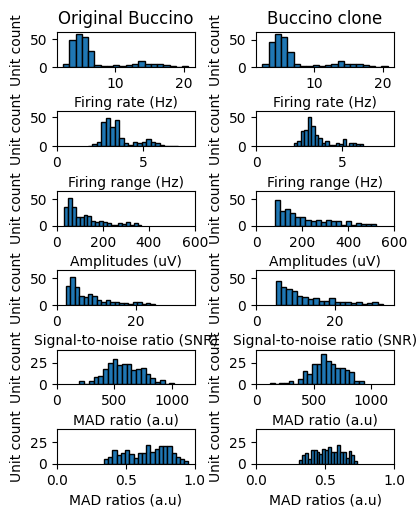

In [ ]:
%%time

# setup  plot 
fig, axes = plt.subplots(6,2, figsize=(4,5))

# SPIKING FEATURES ---------------

# firing rates
firing_rates = get_firing_rates(SortingBuccino, duration_s=600) # original Buccino
plot_firing_rate_distribution(axes[0,0], firing_rates, title='Original Buccino')

firing_rates = get_firing_rates(SortingClone, duration_s=600) # our Buccino clone
plot_firing_rate_distribution(axes[0,1], firing_rates, title='Buccino clone')

# firing range
firing_ranges = get_firing_ranges(WeOriginal)
plot_firing_ranges_distribution(axes[1,0], firing_ranges, title='', ylim=(0,60), xlim=(0,8))

firing_ranges = get_firing_ranges(WeClone)
plot_firing_ranges_distribution(axes[1,1], firing_ranges, title='', ylim=(0,60), xlim=(0,8))


# WAVEFORM FEATURES ---------------

# waveform amplitudes
amplitudes_o = get_waveform_amplitude_medians(WeOriginal)
plot_waveform_amplitude_median_distribution(axes[2,0], amplitudes_o, title='', ylim=(0,65), xlim=(0,600))

amplitudes_c = get_waveform_amplitude_medians(WeClone)
plot_waveform_amplitude_median_distribution(axes[2,1], amplitudes_c, title='', ylim=(0,65), xlim=(0,600))

# signal-to-noise ratio (SNR)
snrs = get_waveform_snr(WeOriginal)
plot_waveform_snr_distribution(axes[3,0], snrs, title='', ylim=(0,65), xlim=(0,35))

snrs = get_waveform_snr(WeClone)
plot_waveform_snr_distribution(axes[3,1], snrs, title='', ylim=(0,65), xlim=(0,35))

# spatial spread
spreads = get_spatial_spread_all_units(RECORDING_BUCCINO_PATH, WAVEFORM_BUCCINO_PATH, ms_before=3, ms_after=3, peak_sign="neg")
plot_spatial_spread_distribution(axes[4,0], spreads, title='', ylim=(0,40), xlim=(0,1200))

spreads = get_spatial_spread_all_units(RECORDING_CLONE_PATH, WAVEFORM_CLONE_PATH, ms_before=3, ms_after=3, peak_sign="neg")
plot_spatial_spread_distribution(axes[4,1], spreads, title='', ylim=(0,40), xlim=(0,1200))

# mad ratio
mad_ratios = get_mad_ratios(WeOriginal)
plot_mad_ratio_distribution(axes[5,0], mad_ratios, title='', ylim=(0,40), xlim=(0,1))

mad_ratios = get_mad_ratios(WeClone)
plot_mad_ratio_distribution(axes[5,1], mad_ratios, title='', ylim=(0,40), xlim=(0,1))

# POSITIONS -----------------------

# distances to electrode

fig.tight_layout(pad=0.1)

In [ ]:
# TRACES
# - amplitude-to-noise ratio (ANR) distribution
# - background noise

In [ ]:
# Sorting yields

In [ ]:
# # clean up default temporary data - you will need to reinstall mearec afterward with pip intall mearec
# import shutil
# shutil.rmtree(CELLS_PATH, ignore_errors=True)